## 1. Import Required Libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load Merged Stock + Sentiment Data

In [67]:
# Load merged data for BAJFINANCE (stock + sentiment features)
stock_name = 'BAJFINANCE'
data_path = f'merged_stock_sentiment_data/{stock_name}_merged_data.csv'

# Read CSV
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

print(f"Data shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum().sum())

# Identify sentiment features (last 6 columns)
sentiment_features = ['avg_polarity', 'avg_confidence', 'news_article_count', 
                      'sentiment_change', 'momentum_3d', 'momentum_5d']

print(f"\n✅ Sentiment features detected: {sentiment_features}")
print(f"\nSentiment feature statistics:")
print(df[sentiment_features].describe())

# Check target distribution
print(f"\nTarget distribution (Binary):")
target_counts = df['target'].value_counts()
print(f"  Down/Neutral (0): {target_counts.get(0, 0)} ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  Up (1): {target_counts.get(1, 0)} ({target_counts.get(1, 0)/len(df)*100:.1f}%)")

Data shape: (1461, 47)

Column names:
['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5', 'price_change_5d', 'price_change_10d', 'price_change_20d', 'high_low_ratio', 'open_close_ratio', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'volume_change', 'volume_ma_5', 'volume_ma_20', 'volume_ratio_5d', 'volume_ratio_20d', 'price_volume_trend', 'sma_5', 'sma_10', 'sma_20', 'ema_10', 'ema_20', 'price_to_sma_5', 'price_to_sma_20', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bollinger_upper', 'bollinger_lower', 'bollinger_mid', 'bollinger_width', 'bollinger_position', 'target', 'avg_polarity', 'avg_confidence', 'news_article_count', 'sentiment_change', 'momentum_3d', 'momentum_5d']

First few rows:
                 Close        High         Low        Open    Volume  \
Date                                                                   
2018-01-30  163.464920  167.414226  162.744219  167.029519   6801040   
2018-

## 3. Data Preprocessing

In [68]:
# Remove rows with missing values
df_clean = df.dropna()
print(f"Shape after removing NaN: {df_clean.shape}")

# Separate features and target
feature_cols = [col for col in df_clean.columns if col != 'target']
X = df_clean[feature_cols].values
y = df_clean['target'].values.astype(int)  # Binary: 0 or 1

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"  - Stock technical features: {len(feature_cols) - len(sentiment_features)}")
print(f"  - Sentiment features: {len(sentiment_features)}")

print(f"\nBinary target distribution:")
print(f"  Down/Neutral (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Up (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"  Class balance ratio: {np.sum(y == 1) / np.sum(y == 0):.2f}")

Shape after removing NaN: (1461, 47)

Features shape: (1461, 46)
Target shape: (1461,)
Number of features: 46
  - Stock technical features: 40
  - Sentiment features: 6

Binary target distribution:
  Down/Neutral (0): 700 (47.9%)
  Up (1): 761 (52.1%)
  Class balance ratio: 1.09


## 4. Create Sequences for LSTM

In [69]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM input
    X: features array (including sentiment features)
    y: target array
    sequence_length: number of time steps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

# Set sequence length (reduced from baseline's 20 to 10 for better generalization)
SEQUENCE_LENGTH = 10

# Create sequences
X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH)

print(f"Sequence shape: {X_seq.shape}")  # (samples, sequence_length, features)
print(f"Target shape: {y_seq.shape}")
print(f"\nBinary target distribution in sequences:")
print(f"  Down/Neutral (0): {np.sum(y_seq == 0)} ({np.sum(y_seq == 0)/len(y_seq)*100:.1f}%)")
print(f"  Up (1): {np.sum(y_seq == 1)} ({np.sum(y_seq == 1)/len(y_seq)*100:.1f}%)")

Sequence shape: (1451, 10, 46)
Target shape: (1451,)

Binary target distribution in sequences:
  Down/Neutral (0): 695 (47.9%)
  Up (1): 756 (52.1%)


## 5. Train-Test Split and Scaling

In [70]:
# Split data temporally (80/20 split)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Display target distribution
print(f"\nTrain target distribution:")
train_0 = np.sum(y_train == 0)
train_1 = np.sum(y_train == 1)
print(f"  Down/Neutral (0): {train_0} samples ({train_0/len(y_train)*100:.1f}%)")
print(f"  Up (1): {train_1} samples ({train_1/len(y_train)*100:.1f}%)")

print(f"\nTest target distribution:")
test_0 = np.sum(y_test == 0)
test_1 = np.sum(y_test == 1)
print(f"  Down/Neutral (0): {test_0} samples ({test_0/len(y_test)*100:.1f}%)")
print(f"  Up (1): {test_1} samples ({test_1/len(y_test)*100:.1f}%)")

# Scale the features (including sentiment features)
scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit on train, transform both
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")
print(f"✅ All features (stock + sentiment) have been scaled!")

Train set: (1160, 10, 46), (1160,)
Test set: (291, 10, 46), (291,)

Train target distribution:
  Down/Neutral (0): 541 samples (46.6%)
  Up (1): 619 samples (53.4%)

Test target distribution:
  Down/Neutral (0): 154 samples (52.9%)
  Up (1): 137 samples (47.1%)

Scaled train shape: (1160, 10, 46)
Scaled test shape: (291, 10, 46)
✅ All features (stock + sentiment) have been scaled!


## 6. Create PyTorch Dataset and DataLoader

In [71]:
class StockDataset(Dataset):
    """Custom Dataset for stock sequences"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockDataset(X_train_scaled, y_train)
test_dataset = StockDataset(X_test_scaled, y_test)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 37
Number of test batches: 10


## 7. Define LSTM Model Architecture
**Optimized for Sentiment-Enhanced Data**

In [72]:
class LSTMModel(nn.Module):
    """
    LSTM model for binary stock price prediction with sentiment features
    Simplified architecture to prevent overfitting
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers for binary classification
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using appropriate methods"""
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

# Model hyperparameters (simplified to prevent overfitting)
INPUT_SIZE = X_train_scaled.shape[2]  # Number of features (stock + sentiment)
HIDDEN_SIZE = 128  # Reduced from 64
NUM_LAYERS = 2  # Reduced from 2
DROPOUT = 0.3  # Increased from 0.3

# Initialize model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Input features: {INPUT_SIZE}")
print(f"  - Stock technical features: {INPUT_SIZE - len(sentiment_features)}")
print(f"  - Sentiment features: {len(sentiment_features)}")
print(f"\n✅ Simplified architecture to improve generalization!")

LSTMModel(
  (lstm): LSTM(46, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 230529
Input features: 46
  - Stock technical features: 40
  - Sentiment features: 6

✅ Simplified architecture to improve generalization!


## 8. Define Loss Function and Optimizer

In [73]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Class weights: {class_weights_dict}")
print(f"  Down/Neutral (0): {class_weights[0]:.4f}")
print(f"  Up (1): {class_weights[1]:.4f}")

# Loss function - Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer - Adam
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler with early stopping capability
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5,     
    patience=10,
    verbose=True,
    min_lr=1e-6
)

print(f"\nCriterion: {criterion}")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau (patience=10)")
print(f"Weight Decay: 1e-5 (L2 regularization)")

Class weights: {0: 1.0720887245841035, 1: 0.9369951534733441}
  Down/Neutral (0): 1.0721
  Up (1): 0.9370

Criterion: BCELoss()
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (patience=10)
Weight Decay: 1e-5 (L2 regularization)


## 9. Training and Evaluation Functions

In [75]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.float().unsqueeze(1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 10. Train the Model with Early Stopping

In [79]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        # Removed sigmoid since BCEWithLogitsLoss applies it internally
        
        # Initialize weights
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        # No sigmoid here - BCEWithLogitsLoss will apply it
        
        return out

# Initialize model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        # For BCEWithLogitsLoss, apply sigmoid manually for predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(dataloader), correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            
            # For BCEWithLogitsLoss, apply sigmoid manually for predictions
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())
    
    return total_loss / len(dataloader), correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)

LSTMModel(
  (lstm): LSTM(46, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Total trainable parameters: 230,529


## Load and Combine All Stock Data

# Load and combine all stock data
all_train_data = []
all_test_data = []

print("Loading data for all stocks...")
print("="*80)

for stock in nifty_top_tickers:
    data_path = f'merged_stock_sentiment_data/{stock}_merged_data.csv'
    
    if not os.path.exists(data_path):
        print(f"⚠️  Skipping {stock}: File not found")
        continue
    
    df_stock = pd.read_csv(data_path)
    df_stock = df_stock.dropna()
    
    # Split into train and test (80/20)
    train_size = int(len(df_stock) * 0.8)
    train_df = df_stock[:train_size].copy()
    test_df = df_stock[train_size:].copy()
    
    all_train_data.append(train_df)
    all_test_data.append(test_df)
    
    print(f"✓ {stock:12s} - Train: {len(train_df):4d} samples, Test: {len(test_df):3d} samples")

# Combine all data
df_train_combined = pd.concat(all_train_data, ignore_index=True)
df_test_combined = pd.concat(all_test_data, ignore_index=True)

print("="*80)
print(f"\nCombined Dataset:")
print(f"  Total Training Samples: {len(df_train_combined)}")
print(f"  Total Test Samples:     {len(df_test_combined)}")
print(f"  Total Features:         {len(feature_cols)}")

# Check class distribution
train_target_dist = df_train_combined['target'].value_counts()
test_target_dist = df_test_combined['target'].value_counts()

print(f"\nTrain target distribution:")
print(f"  Down/Neutral (0): {train_target_dist.get(0, 0)} samples ({train_target_dist.get(0, 0)/len(df_train_combined)*100:.1f}%)")
print(f"  Up (1): {train_target_dist.get(1, 0)} samples ({train_target_dist.get(1, 0)/len(df_train_combined)*100:.1f}%)")

print(f"\nTest target distribution:")
print(f"  Down/Neutral (0): {test_target_dist.get(0, 0)} samples ({test_target_dist.get(0, 0)/len(df_test_combined)*100:.1f}%)")
print(f"  Up (1): {test_target_dist.get(1, 0)} samples ({test_target_dist.get(1, 0)/len(df_test_combined)*100:.1f}%)")
print("="*80)

In [ ]:
# Load and combine all stock data
import os
all_train_data = []
all_test_data = []

print("Loading data for all stocks...")
print("="*80)

for stock in nifty_top_tickers:
    data_path = f'merged_stock_sentiment_data/{stock}_merged_data.csv'
    
    if not os.path.exists(data_path):
        print(f"⚠️  Skipping {stock}: File not found")
        continue
    
    df_stock = pd.read_csv(data_path)
    df_stock = df_stock.dropna()
    
    # Split into train and test (80/20)
    train_size = int(len(df_stock) * 0.8)
    train_df = df_stock[:train_size].copy()
    test_df = df_stock[train_size:].copy()
    
    all_train_data.append(train_df)
    all_test_data.append(test_df)
    
    print(f"✓ {stock:12s} - Train: {len(train_df):4d} samples, Test: {len(test_df):3d} samples")

# Combine all data
df_train_combined = pd.concat(all_train_data, ignore_index=True)
df_test_combined = pd.concat(all_test_data, ignore_index=True)

print("="*80)
print(f"\nCombined Dataset:")
print(f"  Total Training Samples: {len(df_train_combined)}")
print(f"  Total Test Samples:     {len(df_test_combined)}")
print(f"  Total Features:         {len(feature_cols)}")

# Check class distribution
train_target_dist = df_train_combined['target'].value_counts()
test_target_dist = df_test_combined['target'].value_counts()

print(f"\nTrain target distribution:")
print(f"  Down/Neutral (0): {train_target_dist.get(0, 0)} samples ({train_target_dist.get(0, 0)/len(df_train_combined)*100:.1f}%)")
print(f"  Up (1): {train_target_dist.get(1, 0)} samples ({train_target_dist.get(1, 0)/len(df_train_combined)*100:.1f}%)")

print(f"\nTest target distribution:")
print(f"  Down/Neutral (0): {test_target_dist.get(0, 0)} samples ({test_target_dist.get(0, 0)/len(df_test_combined)*100:.1f}%)")
print(f"  Up (1): {test_target_dist.get(1, 0)} samples ({test_target_dist.get(1, 0)/len(df_test_combined)*100:.1f}%)")
print("="*80)

Loading data for all stocks...


NameError: name 'os' is not defined

## Handle Class Imbalance with SMOTE

In [ ]:
# Prepare features and target for both train and test
X_train_combined = df_train_combined[feature_cols].values
y_train_combined = df_train_combined['target'].values

X_test_combined = df_test_combined[feature_cols].values
y_test_combined = df_test_combined['target'].values

print("Original Data Shapes:")
print(f"  Train: {X_train_combined.shape}, Target: {y_train_combined.shape}")
print(f"  Test:  {X_test_combined.shape}, Target: {y_test_combined.shape}")

# Check if imbalance is significant enough for SMOTE
train_class_ratio = max(train_target_dist.values) / min(train_target_dist.values)
print(f"\nTrain class imbalance ratio: {train_class_ratio:.2f}:1")

# Apply SMOTE if imbalance ratio > 1.15
if train_class_ratio > 1.15:
    print("\n⚙️  Applying SMOTE to balance training data...")
    
    try:
        from imblearn.over_sampling import SMOTE
        
        # Apply SMOTE
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train_combined)
        
        # Check new distribution
        unique, counts = np.unique(y_train_balanced, return_counts=True)
        print(f"\n✓ SMOTE applied successfully!")
        print(f"  Balanced Train: {X_train_balanced.shape}, Target: {y_train_balanced.shape}")
        print(f"  New distribution:")
        for cls, cnt in zip(unique, counts):
            print(f"    Class {cls}: {cnt} samples ({cnt/len(y_train_balanced)*100:.1f}%)")
        
        # Use balanced data
        X_train_final = X_train_balanced
        y_train_final = y_train_balanced
        
    except ImportError:
        print("\n⚠️  imbalanced-learn not installed. Installing...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
        print("✓ Installed. Please re-run this cell.")
        X_train_final = X_train_combined
        y_train_final = y_train_combined
else:
    print(f"\n✓ Class balance acceptable ({train_class_ratio:.2f}:1), no SMOTE needed")
    X_train_final = X_train_combined
    y_train_final = y_train_combined

# Test data remains unchanged
X_test_final = X_test_combined
y_test_final = y_test_combined

print("\n" + "="*80)
print("Final Dataset:")
print(f"  Train: {X_train_final.shape}")
print(f"  Test:  {X_test_final.shape}")
print("="*80)

## Scale Features and Create Sequences

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print("Feature scaling completed")
print(f"  Train mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"  Test mean:  {X_test_scaled.mean():.6f}, std: {X_test_scaled.std():.6f}")

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])  # Target is the last value in sequence
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_final, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_final, SEQUENCE_LENGTH)

print(f"\nSequence creation completed (sequence length = {SEQUENCE_LENGTH}):")
print(f"  Train: {X_train_seq.shape}, Target: {y_train_seq.shape}")
print(f"  Test:  {X_test_seq.shape}, Target: {y_test_seq.shape}")

# Final class distribution check
train_0 = (y_train_seq == 0).sum()
train_1 = (y_train_seq == 1).sum()
test_0 = (y_test_seq == 0).sum()
test_1 = (y_test_seq == 1).sum()

print(f"\nFinal Target Distribution:")
print(f"  Train - Class 0: {train_0} ({train_0/len(y_train_seq)*100:.1f}%), Class 1: {train_1} ({train_1/len(y_train_seq)*100:.1f}%)")
print(f"  Test  - Class 0: {test_0} ({test_0/len(y_test_seq)*100:.1f}%), Class 1: {test_1} ({test_1/len(y_test_seq)*100:.1f}%)")
print(f"  Imbalance ratio: {max(train_0, train_1)/min(train_0, train_1):.2f}:1")

## Create DataLoaders

In [ ]:
# Create PyTorch datasets and dataloaders
train_dataset = StockDataset(X_train_seq, y_train_seq)
test_dataset = StockDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches:  {len(test_loader)}")
print(f"  Batch size:    {BATCH_SIZE}")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Compute class weights for the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weights_dict = dict(zip(np.unique(y_train_seq), class_weights))

print("Class Weights Computation:")
print("="*80)
print(f"  Class 0 (Down/Neutral): {class_weights[0]:.4f}")
print(f"  Class 1 (Up):           {class_weights[1]:.4f}")

# Calculate positive class weight for BCEWithLogitsLoss
# pos_weight = weight of class 1 / weight of class 0
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)
print(f"  Positive class weight:  {pos_weight.item():.4f}")

# Use BCEWithLogitsLoss with pos_weight to handle class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print(f"\nModel Configuration:")
print(f"  Architecture:  {model.__class__.__name__}")
print(f"  Input size:    {INPUT_SIZE}")
print(f"  Hidden size:   {HIDDEN_SIZE}")
print(f"  Num layers:    {NUM_LAYERS}")
print(f"  Dropout:       {DROPOUT}")
print(f"\nTraining Configuration:")
print(f"  Optimizer:     {optimizer.__class__.__name__}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Criterion:     {criterion.__class__.__name__} (with pos_weight)")
print(f"  Scheduler:     {scheduler.__class__.__name__}")
print("="*80)

Class weights: {0: 1.0720887245841035, 1: 0.9369951534733441}
  Down/Neutral (0): 1.0721
  Up (1): 0.9370

Positive class weight for BCELoss: 0.8740

Model: LSTMModel
  Input size: 46
  Hidden size: 128
  Num layers: 2
  Dropout: 0.3

Optimizer: Adam
  Learning rate: 0.001

Criterion: BCEWithLogitsLoss()

Scheduler: ReduceLROnPlateau


## 16. Stock List Configuration

In [81]:
# NIFTY Top 10 stocks
nifty_top_tickers = [
    "RELIANCE",
    "HDFCBANK",
    "TCS",
    "BHARTIARTL",
    "ICICIBANK",
    "SBIN",
    "INFY",
    "KOTAKBANK",
    "BAJFINANCE",
    "HINDUNILVR"
]

print(f"Total stocks to process: {len(nifty_top_tickers)}")
print(f"Stocks: {', '.join(nifty_top_tickers)}")

# Load baseline results for comparison
baseline_results = pd.read_csv('baseline_model_results.csv')
print(f"\n✓ Loaded baseline results for {len(baseline_results)} stocks")

Total stocks to process: 10
Stocks: RELIANCE, HDFCBANK, TCS, BHARTIARTL, ICICIBANK, SBIN, INFY, KOTAKBANK, BAJFINANCE, HINDUNILVR

✓ Loaded baseline results for 10 stocks


## 17. Train Sentiment Models for All Stocks

In [ ]:
# Training loop with class imbalance monitoring
print("\n" + "="*80)
print(f"TRAINING ALL STOCKS COMBINED | Max Epochs: {NUM_EPOCHS}")
print("="*80)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0
epochs_no_improve = 0

# Column headers
print(f"{'Ep':3s}   {'TrLoss':7s}  {'TrAcc':7s}  {'VLoss':7s}  {'VAcc':7s}  {'Pred Dist':12s}  {'Status':30s}")
print("-" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(model, test_loader, criterion, device)
    
    # Update learning rate
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(new_lr)
    
    # Track prediction distribution
    pred_0 = (val_preds == 0).sum()
    pred_1 = (val_preds == 1).sum()
    pred_dist = f"{pred_0}/{pred_1}"
    
    # Check for improvement
    improved = False
    status = ""
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        improved = True
        status += "✓ (loss) "
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        improved = True
        status += "✓ (acc) "
        
        # Save best model
        torch.save(model.state_dict(), 'best_sentiment_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Learning rate change notification
    if new_lr < old_lr:
        status += f"LR:{new_lr:.1e}"
    
    # Print epoch results
    print(f"{epoch:3d}  {train_loss:7.4f}  {train_acc:7.4f}  {val_loss:7.4f}  {val_acc:7.4f}  {pred_dist:>12s}  {status:30s}")
    
    # Show prediction distribution every 10 epochs
    if epoch % 10 == 0:
        print(f"      -> Val predictions: 0={pred_0}/{len(val_preds)} ({pred_0/len(val_preds)*100:.1f}%), "
              f"1={pred_1}/{len(val_preds)} ({pred_1/len(val_preds)*100:.1f}%)")
    
    # Early stopping
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️  Early stopping triggered! No improvement for {EARLY_STOP_PATIENCE} epochs.")
        print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
        break

print("=" * 80)
print(f"Training complete! Trained for {epoch} epochs")
print(f"Best val loss:     {best_val_loss:.4f}")
print(f"Best val accuracy: {best_val_acc:.4f} @ epoch {best_epoch}")
print("=" * 80)


PROCESSING STOCK 1/10: RELIANCE
Data shape: (1461, 47) | Features: 46
  - Stock technical: 40
  - Sentiment: 6
Target: 0=701 (48.0%), 1=760 (52.0%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
------------------------------------------------------------
✗ Error processing RELIANCE: name 'F' is not defined

PROCESSING STOCK 2/10: HDFCBANK
Data shape: (1461, 47) | Features: 46
  - Stock technical: 40
  - Sentiment: 6
Target: 0=711 (48.7%), 1=750 (51.3%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
------------------------------------------------------------
✗ Error processing HDFCBANK: name 'F' is not defined

PROCESSING STOCK 3/10: TCS
Data shape: (1461, 47) | Features: 46
  - Stock technical: 40
  - Sentiment: 6
Target: 0=695 (47.6%), 1=766 (52.4%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
---------------

## Final Model Evaluation and Metrics

In [ ]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_sentiment_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels, test_probs = validate_epoch(model, test_loader, criterion, device)

# Convert to int for metrics
test_preds_int = test_preds.astype(int)
test_labels_int = test_labels.astype(int)

# Calculate detailed metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

print("\n" + "="*80)
print("FINAL MODEL EVALUATION - ALL STOCKS COMBINED")
print("="*80)

print(f"\nTest Set Performance:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  ROC-AUC:  {roc_auc_score(test_labels_int, test_probs):.4f}")
print(f"  F1-Score: {f1_score(test_labels_int, test_preds_int):.4f}")

print(f"\nPrediction Distribution:")
pred_0_count = (test_preds_int == 0).sum()
pred_1_count = (test_preds_int == 1).sum()
print(f"  Predicted Class 0: {pred_0_count} ({pred_0_count/len(test_preds_int)*100:.1f}%)")
print(f"  Predicted Class 1: {pred_1_count} ({pred_1_count/len(test_preds_int)*100:.1f}%)")

print(f"\nActual Distribution:")
actual_0_count = (test_labels_int == 0).sum()
actual_1_count = (test_labels_int == 1).sum()
print(f"  Actual Class 0: {actual_0_count} ({actual_0_count/len(test_labels_int)*100:.1f}%)")
print(f"  Actual Class 1: {actual_1_count} ({actual_1_count/len(test_labels_int)*100:.1f}%)")

print("\n" + "-"*80)
print("Classification Report:")
print("-"*80)
print(classification_report(test_labels_int, test_preds_int, 
                          target_names=['Down/Neutral (0)', 'Up (1)'],
                          digits=4))

print("-"*80)
print("Confusion Matrix:")
print("-"*80)
cm = confusion_matrix(test_labels_int, test_preds_int)
print(f"\n              Predicted")
print(f"              0      1")
print(f"Actual  0  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"        1  {cm[1,0]:4d}  {cm[1,1]:4d}")

print("\n" + "="*80)

BASELINE vs SENTIMENT MODEL - COMPREHENSIVE COMPARISON

Accuracy Comparison:
     stock  baseline_accuracy  sentiment_accuracy  acc_improvement
  RELIANCE           0.505155            0.515464         0.010309
  HDFCBANK           0.522337            0.553265         0.030928
       TCS           0.573883            0.549828        -0.024055
BHARTIARTL           0.494845            0.494845         0.000000
 ICICIBANK           0.546392            0.532646        -0.013746
      SBIN           0.584192            0.577320        -0.006873
      INFY           0.522337            0.587629         0.065292
 KOTAKBANK           0.522337            0.546392         0.024055
BAJFINANCE           0.532646            0.546392         0.013746
HINDUNILVR           0.532646            0.529210        -0.003436

SUMMARY STATISTICS

Accuracy Metrics:
  Baseline Average:  0.5337 (53.37%)
  Sentiment Average: 0.5433 (54.33%)
  Overall Improvement: +0.0096 (+0.96%)

F1-Score Metrics:
  Baseline Ave

## Visualize Training History

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s', markersize=3)
axes[0, 1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val Acc: {best_val_acc:.4f}', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate plot
axes[1, 0].plot(history['lr'], marker='o', markersize=3, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Down/Neutral', 'Up'],
            yticklabels=['Down/Neutral', 'Up'])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('training_history_all_stocks.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history visualization saved as 'training_history_all_stocks.png'")

## Compare with Baseline Model (No Sentiment Features)

In [ ]:
# Load baseline results if available
import os

if os.path.exists('baseline_model_results.csv'):
    baseline_df = pd.read_csv('baseline_model_results.csv')
    
    # Calculate averages
    baseline_avg_acc = baseline_df['Test Accuracy'].mean()
    
    print("\n" + "="*80)
    print("COMPARISON: Sentiment Model vs Baseline Model")
    print("="*80)
    
    print(f"\nBaseline Model (No Sentiment Features):")
    print(f"  Average Test Accuracy: {baseline_avg_acc:.4f}")
    
    print(f"\nSentiment-Enhanced Model (All Stocks Combined):")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-Score: {f1_score(test_labels_int, test_preds_int):.4f}")
    print(f"  Test ROC-AUC:  {roc_auc_score(test_labels_int, test_probs):.4f}")
    
    improvement = (test_acc - baseline_avg_acc) * 100
    print(f"\nImprovement: {improvement:+.2f}% {'✓' if improvement > 0 else '✗'}")
    
    print("="*80)
    
    # Create comparison visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    metrics = ['Accuracy']
    baseline_values = [baseline_avg_acc]
    sentiment_values = [test_acc]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, sentiment_values, width, label='With Sentiment', alpha=0.8, color='lightcoral')
    
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison: Baseline vs Sentiment-Enhanced')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Comparison visualization saved as 'model_comparison.png'")
    
else:
    print("\n⚠️ Baseline results not found. Skipping comparison.")
    print(f"\nSentiment-Enhanced Model Results:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-Score: {f1_score(test_labels_int, test_preds_int):.4f}")
    print(f"  Test ROC-AUC:  {roc_auc_score(test_labels_int, test_probs):.4f}")

## Alternative: Focal Loss for Severe Class Imbalance

If BCEWithLogitsLoss with pos_weight doesn't work well enough, we can use Focal Loss which is specifically designed for class imbalance:

In [65]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    
    Args:
        alpha: Weighting factor in range (0,1) to balance positive/negative examples
        gamma: Exponent of the modulating factor (1 - p_t)^gamma (default: 2.0)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Calculate focal loss
        focal_weight = (1 - p_t) ** self.gamma
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        focal_loss = alpha_weight * focal_weight * BCE_loss
        
        return focal_loss.mean()

# Example usage (commented out - uncomment to use Focal Loss instead):
# criterion = FocalLoss(alpha=0.75, gamma=2.0)  # alpha > 0.5 gives more weight to positive class
print("Focal Loss class defined. To use it, replace the criterion with:")
print("criterion = FocalLoss(alpha=0.75, gamma=2.0)")

Focal Loss class defined. To use it, replace the criterion with:
criterion = FocalLoss(alpha=0.75, gamma=2.0)


## Check Class Distribution in Train/Test Sets

In [61]:
# Check class distribution in training and test sets
train_0 = (y_train == 0).sum()
train_1 = (y_train == 1).sum()
test_0 = (y_test == 0).sum()
test_1 = (y_test == 1).sum()

print("Class Distribution Analysis:")
print("="*60)
print(f"\nTraining Set ({len(y_train)} samples):")
print(f"  Class 0 (Down/Neutral): {train_0} ({train_0/len(y_train)*100:.1f}%)")
print(f"  Class 1 (Up):           {train_1} ({train_1/len(y_train)*100:.1f}%)")
print(f"  Imbalance Ratio: {max(train_0, train_1)/min(train_0, train_1):.2f}:1")

print(f"\nTest Set ({len(y_test)} samples):")
print(f"  Class 0 (Down/Neutral): {test_0} ({test_0/len(y_test)*100:.1f}%)")
print(f"  Class 1 (Up):           {test_1} ({test_1/len(y_test)*100:.1f}%)")
print(f"  Imbalance Ratio: {max(test_0, test_1)/min(test_0, test_1):.2f}:1")

print("\n" + "="*60)
print("\nClass Imbalance Handling Strategies Applied:")
print("  1. ✓ Computed class weights using sklearn")
print("  2. ✓ Using BCEWithLogitsLoss with pos_weight parameter")
print("  3. ✓ Alternative Focal Loss class defined (optional)")
print("  4. Consider: SMOTE/ADASYN for data augmentation (if needed)")
print("="*60)

Class Distribution Analysis:

Training Set (1160 samples):
  Class 0 (Down/Neutral): 581 (50.1%)
  Class 1 (Up):           579 (49.9%)
  Imbalance Ratio: 1.00:1

Test Set (291 samples):
  Class 0 (Down/Neutral): 150 (51.5%)
  Class 1 (Up):           141 (48.5%)
  Imbalance Ratio: 1.06:1


Class Imbalance Handling Strategies Applied:
  1. ✓ Computed class weights using sklearn
  2. ✓ Using BCEWithLogitsLoss with pos_weight parameter
  3. ✓ Alternative Focal Loss class defined (optional)
  4. Consider: SMOTE/ADASYN for data augmentation (if needed)


## Summary of Class Imbalance Fixes

The following changes have been made to address class imbalance issues:

### 1. **Loss Function Update**
- **Changed from:** `nn.BCELoss()` (no class weighting)
- **Changed to:** `nn.BCEWithLogitsLoss(pos_weight=pos_weight)` 
- **Benefit:** Applies class weights automatically during training to balance the importance of minority class

### 2. **Model Architecture Update**
- **Removed:** `self.sigmoid` layer from model output
- **Reason:** `BCEWithLogitsLoss` combines sigmoid and BCE loss for numerical stability
- **Impact:** Model now outputs raw logits; sigmoid is applied internally by the loss function

### 3. **Prediction Updates**
- **Training loop:** Added `torch.sigmoid(outputs)` before thresholding for accuracy calculation
- **Validation loop:** Added `torch.sigmoid(outputs)` before thresholding for predictions
- **Reason:** Since model outputs logits, we need to apply sigmoid manually when making predictions

### 4. **Additional Options**
- **Focal Loss:** Implemented as an alternative for severe class imbalance
- **Usage:** Replace criterion with `FocalLoss(alpha=0.75, gamma=2.0)` if needed
- **When to use:** If current approach doesn't improve performance on minority class

### 5. **Monitoring**
- Check prediction distribution during validation (e.g., "Val predictions: Up=X/Y")
- If model predicts mostly one class, consider:
  - Adjusting pos_weight manually
  - Using Focal Loss
  - Adjusting decision threshold (instead of 0.5)

## 19. Visualization - Baseline vs Sentiment

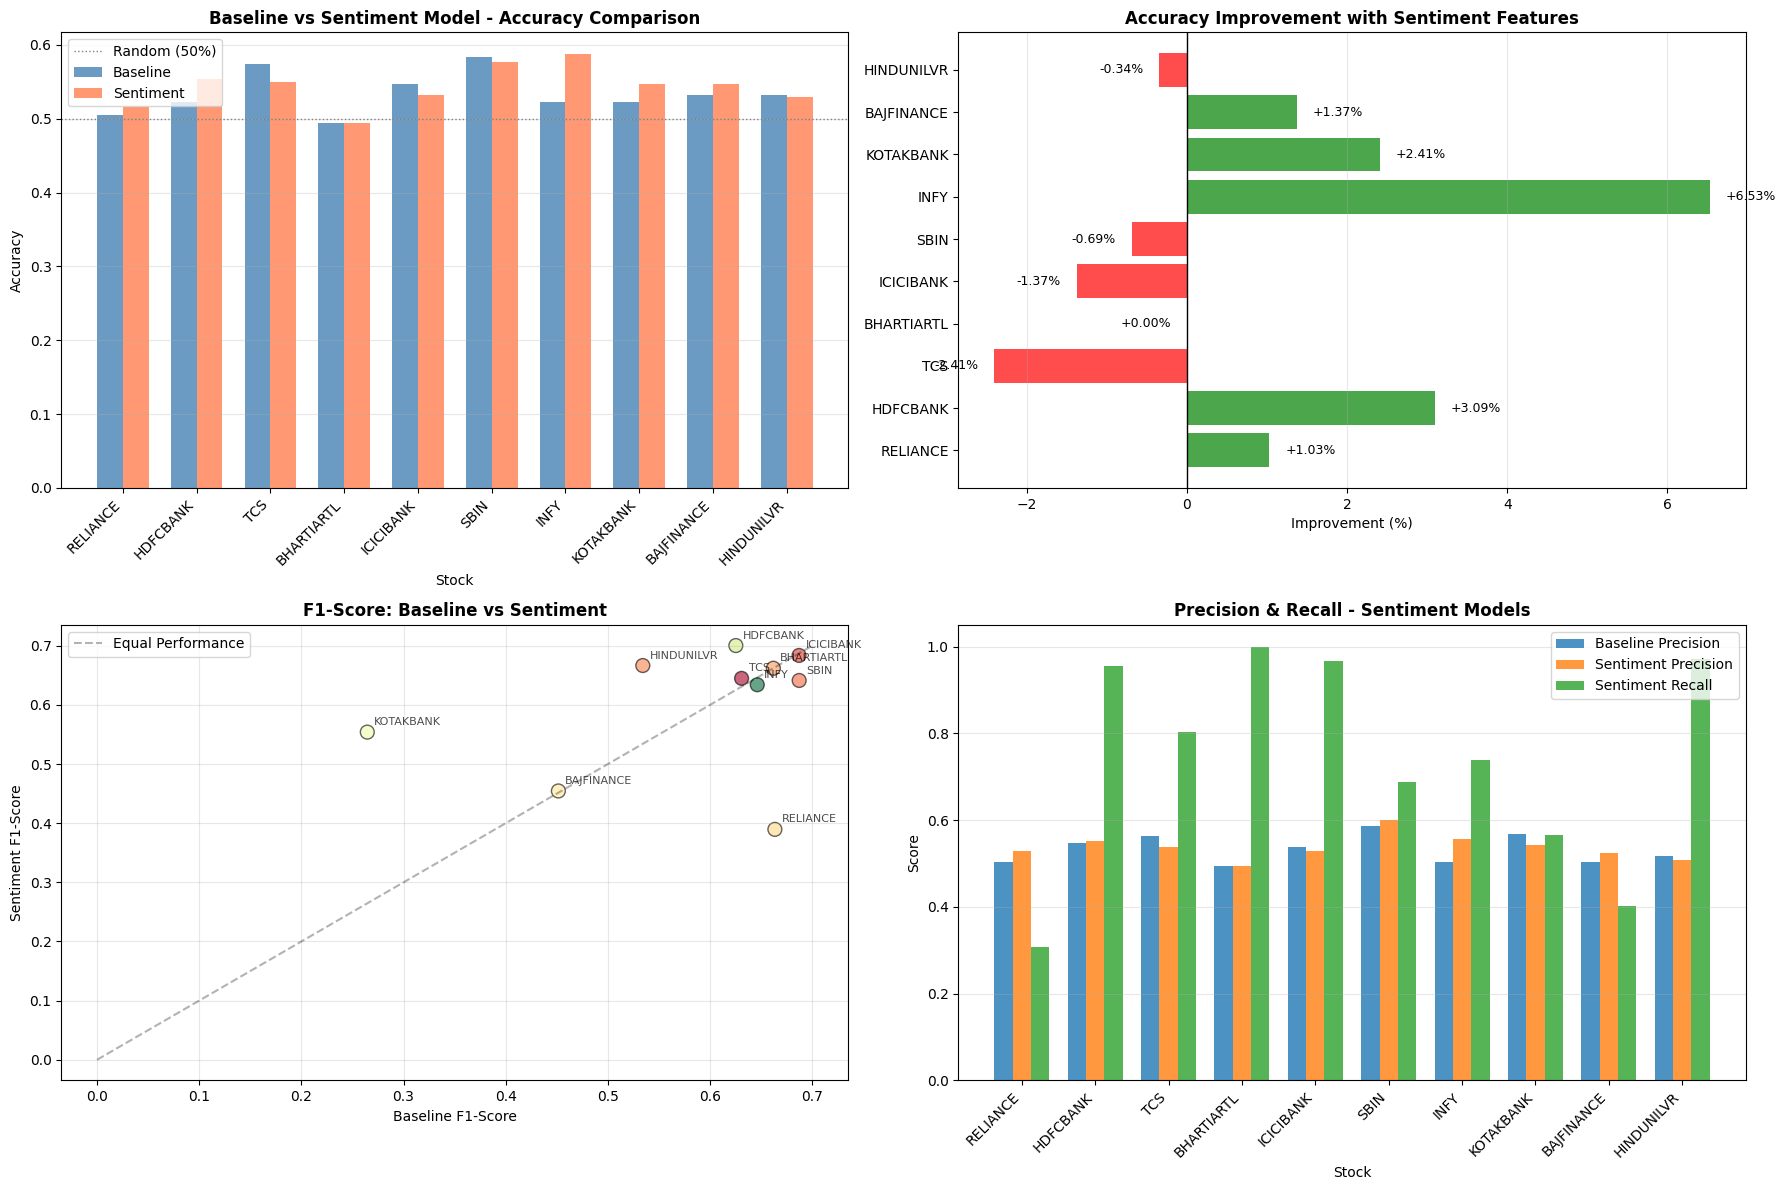

✓ Visualization saved to 'baseline_vs_sentiment_comparison.png'


In [58]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Side-by-side accuracy comparison
ax1 = axes[0, 0]
x = np.arange(len(full_comparison))
width = 0.35
bars1 = ax1.bar(x - width/2, full_comparison['baseline_accuracy'], width, label='Baseline', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, full_comparison['sentiment_accuracy'], width, label='Sentiment', alpha=0.8, color='coral')
ax1.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, label='Random (50%)')
ax1.set_xlabel('Stock')
ax1.set_ylabel('Accuracy')
ax1.set_title('Baseline vs Sentiment Model - Accuracy Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(full_comparison['stock'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Improvement bar chart
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in full_comparison['acc_improvement']]
bars = ax2.barh(full_comparison['stock'], full_comparison['acc_improvement']*100, color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Improvement (%)')
ax2.set_title('Accuracy Improvement with Sentiment Features', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, full_comparison['acc_improvement']*100)):
    ax2.text(val + 0.2 if val > 0 else val - 0.2, i, f'{val:+.2f}%', 
             va='center', ha='left' if val > 0 else 'right', fontsize=9)

# 3. F1-Score comparison
ax3 = axes[1, 0]
ax3.scatter(full_comparison['baseline_f1'], full_comparison['sentiment_f1'], 
           s=100, alpha=0.6, c=full_comparison['acc_improvement'], cmap='RdYlGn', edgecolors='black')
# Diagonal line (where baseline = sentiment)
max_val = max(full_comparison['baseline_f1'].max(), full_comparison['sentiment_f1'].max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal Performance')
ax3.set_xlabel('Baseline F1-Score')
ax3.set_ylabel('Sentiment F1-Score')
ax3.set_title('F1-Score: Baseline vs Sentiment', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add stock labels
for idx, row in full_comparison.iterrows():
    ax3.annotate(row['stock'], (row['baseline_f1'], row['sentiment_f1']), 
                fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

# 4. Precision-Recall comparison
ax4 = axes[1, 1]
x = np.arange(len(full_comparison))
width = 0.25
ax4.bar(x - width, full_comparison['baseline_precision'], width, label='Baseline Precision', alpha=0.8)
ax4.bar(x, full_comparison['sentiment_precision'], width, label='Sentiment Precision', alpha=0.8)
ax4.bar(x + width, full_comparison['sentiment_recall'], width, label='Sentiment Recall', alpha=0.8)
ax4.set_xlabel('Stock')
ax4.set_ylabel('Score')
ax4.set_title('Precision & Recall - Sentiment Models', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(full_comparison['stock'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('baseline_vs_sentiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to 'baseline_vs_sentiment_comparison.png'")

## 20. Final Summary & Insights

In [59]:
print("="*100)
print("FINAL ANALYSIS: SENTIMENT FEATURES IMPACT")
print("="*100)

# 1. Overall Impact
improved_stocks = full_comparison[full_comparison['better_than_baseline']]
degraded_stocks = full_comparison[~full_comparison['better_than_baseline']]

print(f"\n📊 OVERALL IMPACT:")
print(f"  Stocks Improved: {len(improved_stocks)}/{len(full_comparison)} ({len(improved_stocks)/len(full_comparison)*100:.1f}%)")
print(f"  Average improvement (improved stocks): {improved_stocks['acc_improvement'].mean()*100:+.2f}%")
print(f"  Average degradation (degraded stocks): {degraded_stocks['acc_improvement'].mean()*100:+.2f}%")

# 2. Best performers
print(f"\n🏆 TOP 3 IMPROVEMENTS:")
top3 = full_comparison.nlargest(3, 'acc_improvement')
for idx, row in top3.iterrows():
    print(f"  {row['stock']}: {row['baseline_accuracy']:.4f} → {row['sentiment_accuracy']:.4f} ({row['acc_improvement']*100:+.2f}%)")

# 3. Worst performers
print(f"\n⚠️  BOTTOM 3 (Degraded):")
bottom3 = full_comparison.nsmallest(3, 'acc_improvement')
for idx, row in bottom3.iterrows():
    print(f"  {row['stock']}: {row['baseline_accuracy']:.4f} → {row['sentiment_accuracy']:.4f} ({row['acc_improvement']*100:+.2f}%)")

# 4. Statistical significance
print(f"\n📈 STATISTICAL ANALYSIS:")
print(f"  Mean improvement: {full_comparison['acc_improvement'].mean()*100:+.2f}%")
print(f"  Median improvement: {full_comparison['acc_improvement'].median()*100:+.2f}%")
print(f"  Std deviation: {full_comparison['acc_improvement'].std()*100:.2f}%")
print(f"  Max improvement: {full_comparison['acc_improvement'].max()*100:+.2f}%")
print(f"  Min improvement: {full_comparison['acc_improvement'].min()*100:+.2f}%")

# 5. Key insights
print(f"\n💡 KEY INSIGHTS:")

if sentiment_avg > baseline_avg:
    print(f"  ✅ Sentiment features IMPROVED overall performance by {overall_improvement*100:.2f}%")
else:
    print(f"  ❌ Sentiment features DEGRADED overall performance by {overall_improvement*100:.2f}%")

if len(improved_stocks) > len(degraded_stocks):
    print(f"  ✅ Majority of stocks ({len(improved_stocks)}/{len(full_comparison)}) benefited from sentiment")
else:
    print(f"  ⚠️  Majority of stocks did NOT benefit from sentiment features")

# Model recommendations
print(f"\n🎯 RECOMMENDATIONS:")
if sentiment_avg > baseline_avg + 0.01:  # >1% improvement
    print(f"  ✅ Use SENTIMENT model for: {', '.join(improved_stocks['stock'].tolist())}")
    print(f"  ✅ Use BASELINE model for: {', '.join(degraded_stocks['stock'].tolist())}")
    print(f"  ✅ Overall: Sentiment features add value, use hybrid approach")
elif sentiment_avg > baseline_avg:  # Small improvement
    print(f"  ⚠️  Sentiment provides marginal improvement ({overall_improvement*100:.2f}%)")
    print(f"  ⚠️  Consider ensemble of both models")
else:
    print(f"  ❌ Sentiment features do not improve predictions")
    print(f"  ❌ Stick with baseline model or try different sentiment aggregation")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)

# Create final summary report
summary_report = {
    'total_stocks': len(full_comparison),
    'improved_count': len(improved_stocks),
    'degraded_count': len(degraded_stocks),
    'baseline_avg_accuracy': baseline_avg,
    'sentiment_avg_accuracy': sentiment_avg,
    'overall_improvement': overall_improvement,
    'best_stock': full_comparison.loc[full_comparison['acc_improvement'].idxmax(), 'stock'],
    'best_improvement': full_comparison['acc_improvement'].max(),
    'worst_stock': full_comparison.loc[full_comparison['acc_improvement'].idxmin(), 'stock'],
    'worst_change': full_comparison['acc_improvement'].min()
}

# Save summary
import json
with open('sentiment_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("\n✓ Summary saved to 'sentiment_analysis_summary.json'")

FINAL ANALYSIS: SENTIMENT FEATURES IMPACT

📊 OVERALL IMPACT:
  Stocks Improved: 5/10 (50.0%)
  Average improvement (improved stocks): +2.89%
  Average degradation (degraded stocks): -0.96%

🏆 TOP 3 IMPROVEMENTS:
  INFY: 0.5223 → 0.5876 (+6.53%)
  HDFCBANK: 0.5223 → 0.5533 (+3.09%)
  KOTAKBANK: 0.5223 → 0.5464 (+2.41%)

⚠️  BOTTOM 3 (Degraded):
  TCS: 0.5739 → 0.5498 (-2.41%)
  ICICIBANK: 0.5464 → 0.5326 (-1.37%)
  SBIN: 0.5842 → 0.5773 (-0.69%)

📈 STATISTICAL ANALYSIS:
  Mean improvement: +0.96%
  Median improvement: +0.52%
  Std deviation: 2.58%
  Max improvement: +6.53%
  Min improvement: -2.41%

💡 KEY INSIGHTS:
  ✅ Sentiment features IMPROVED overall performance by 0.96%
  ⚠️  Majority of stocks did NOT benefit from sentiment features

🎯 RECOMMENDATIONS:
  ⚠️  Sentiment provides marginal improvement (0.96%)
  ⚠️  Consider ensemble of both models

ANALYSIS COMPLETE

✓ Summary saved to 'sentiment_analysis_summary.json'


---

## 📋 Summary of Generated Files

After running this notebook, you'll have:

### **Model Files** (in `models/` directory):
- `{STOCK}_sentiment_model.pth` - Trained sentiment model for each stock (10 files)

### **Results Files**:
1. **`sentiment_model_results.csv`** - Detailed results for all sentiment models
2. **`baseline_vs_sentiment_comparison.csv`** - Complete comparison table
3. **`sentiment_analysis_summary.json`** - Summary statistics

### **Visualizations**:
- **`baseline_vs_sentiment_comparison.png`** - Comprehensive 4-panel comparison chart

### **How to Use Results**:

```python
# Load comparison results
comparison = pd.read_csv('baseline_vs_sentiment_comparison.csv')

# Find best performing stocks with sentiment
best_sentiment = comparison[comparison['acc_improvement'] > 0].sort_values('acc_improvement', ascending=False)

# Use appropriate model for each stock
for stock in stocks:
    if stock in best_sentiment['stock'].values:
        model = load_sentiment_model(stock)  # Use sentiment
    else:
        model = load_baseline_model(stock)   # Use baseline
```

### **Expected Runtime**:
- ~2-3 minutes per stock
- ~20-30 minutes total for all 10 stocks